In [3]:
"""Here we train the neural net models and DragoNN model"""
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random
import h5py
import math
import sys, os
import csv

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn import svm, linear_model
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve
from sklearn.preprocessing import StandardScaler 

import matplotlib.pyplot as plt

from addFeatureLabels import *

In [33]:
train_data_df = pd.read_csv('enhancer_train_data.csv')
train_data_df = train_data_df.drop('Unnamed: 0', axis=1)

# NOTES: 
# - something screwed up with DNAse data

In [34]:
labels = get_labels()
labels = labels.astype(float)
len(labels)

[-1 -1 -1 ..., -1 -1 -1]


2203

In [35]:
# dnase_data = np.loadtxt('./processed_data/Dnase_processed_4.csv')
DNASE_DIR = './processed_data/Dnase_processed_'

dnase_data = []

for i in range(1, 7): 
    dnase_file = DNASE_DIR + str(i) + '.csv'
    with open(dnase_file) as f:
        dnase = csv.reader(f, delimiter=',')
        curr_dnase = dnase.next()
        dnase_data.append(curr_dnase)



In [48]:
for j in range(6, 0, -1):
    train_data_df['Dnase_processed_' + str(j) + '.csv'] = dnase_data[j - 1]

# train_data_df = train_data_df.drop(['H3K27ac_1.csv'], axis=1)
# train_data_df.drop('H3K27ac_1.csv', axis=1)
train_data_df.to_csv('train_data_fully_processed.csv')
train_data_df

,p300_processed_1.csv,h3k27ac_processed_5.csv,h3k27ac_processed_4.csv,h3k27ac_processed_3.csv,h3k27ac_processed_2.csv,h3k27ac_processed_1.csv,Dnase_processed_6.csv,Dnase_processed_5.csv,Dnase_processed_4.csv,Dnase_processed_3.csv,Dnase_processed_2.csv,Dnase_processed_1.csv
0,32.942400,110.276000,22.797100,29.660800,31.996300,29.458200,29.4582,31.9963,29.6608,22.7971,110.276,32.9424
1,5.129370,13.151700,1.300250,4.221230,11.194700,7.153350,7.15335,11.1947,4.22123,1.30025,13.1517,5.12937
2,31.723000,101.766000,34.040200,29.557700,5.172990,11.121900,11.1219,5.17299,29.5577,34.0402,101.766,31.723
3,10.600000,68.974200,15.916000,21.296800,6.729220,5.314370,5.31437,6.72922,21.2968,15.916,68.9742,10.6
4,11.032400,51.898500,9.877640,9.672350,13.696500,8.721150,8.72115,13.6965,9.67235,9.87764,51.8985,11.0324
5,0.238385,4.019960,0.956641,2.982290,0.970633,0.202598,0.202598,0.970633,2.98229,0.956641,4.01996,0.238385
6,0.950709,13.547800,1.645020,1.900370,1.513450,0.649806,0.649806,1.51345,1.90037,1.64502,13.5478,0.950709
7,1.174640,10.762900,2.184400,10.782700,0.853122,1.776100,1.7761,0.853122,10.7827,2.1844,10.7629,1.17464
8,0.730129,8.313420,0.188372,1.902950,0.010204,0.166147,0.166147,0.0102041,1.90295,0.188372,8.31342,0.730129
9,4.860780,28.423400,11.006800,7.135390,4.835090,2.659480,2.65948,4.83509,7.13539,11.0068,28.4234,4.86078


In [62]:
new_columns = ['p300_processed_1.csv', 'h3k27ac_processed_5.csv', 
               'h3k27ac_processed_4.csv', 'h3k27ac_processed_3.csv', 
               'h3k27ac_processed_2.csv','h3k27ac_processed_1.csv', 
               'Dnase_processed_6.csv', 'Dnase_processed_5.csv',
               'Dnase_processed_4.csv', 'Dnase_processed_3.csv', 
               'Dnase_processed_2.csv', 'Dnase_processed_1.csv'] 

def split_data(examples, labels):
    """Split into positive and negative examples"""
    pos_examples, neg_examples = [], [] 
    for i, ex in enumerate(examples): 
        if labels[i] == 1:
            pos_examples.append(ex)
        
        elif labels[i] == -1:
            neg_examples.append(ex)
    
    return pos_examples, neg_examples 

pos_examples, neg_examples = split_data(train_data_df.values, labels)

pos_df = pd.DataFrame(data=pos_examples, columns=new_columns)
neg_df = pd.DataFrame(data=neg_examples, columns=new_columns)

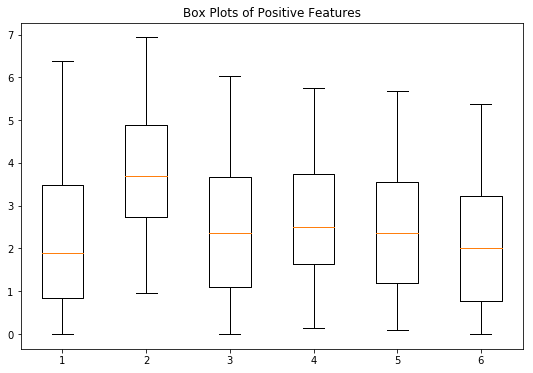

In [63]:
data_to_plot = []
for col in pos_df.columns[:6]:
    data = pos_df[col].values
    data[:] += 1
    data = np.log(data)
    data_to_plot.append(data)

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot)

plt.title('Box Plots of Positive Features')
plt.show()

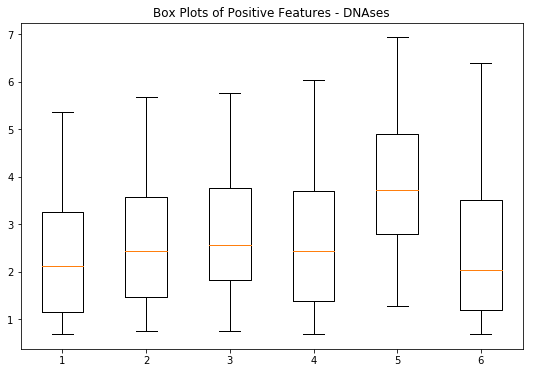

In [67]:
data_to_plot = []
for col in pos_df.columns[6:]:
    pos_df[col] = pos_df[col].astype(float)
    data = pos_df[col].values
    data[:] += 1
    data = np.log(data)
    data_to_plot.append(data)

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot)

plt.title('Box Plots of Positive Features - DNAses')
plt.show()

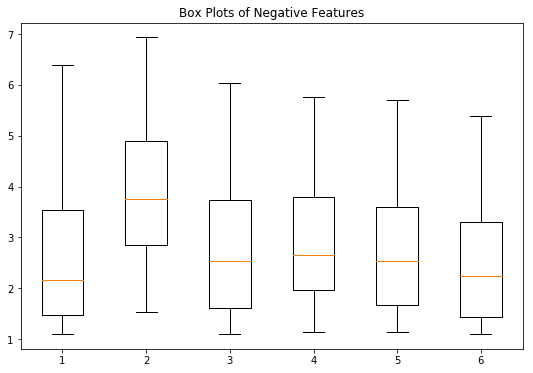

In [68]:
data_to_plot = []
for col in pos_df.columns[:6]:
    neg_df[col] = neg_df[col]
    data = pos_df[col].values
    data[:] += 1
    data = np.log(data)
    data_to_plot.append(data)

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot)

plt.title('Box Plots of Negative Features')
plt.show()

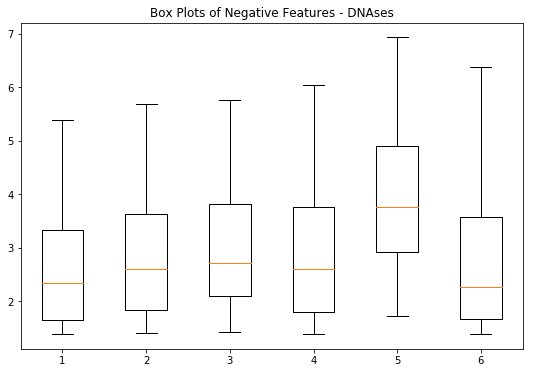

In [84]:
data_to_plot = []
for col in pos_df.columns[6:]:
    neg_df[col] = neg_df[col].astype(float)
    data = pos_df[col].values
    data[:] += 1
    data = np.log(data)
    data_to_plot.append(data)

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot)

plt.title('Box Plots of Negative Features - DNAses')
plt.show()

In [70]:
# Make histogram for p300 vs h3k27ac, p300 vs. DNAse I and h3K27ac vs DNAse I 

scale_all = StandardScaler()
pos_scaler = StandardScaler()
neg_scaler = StandardScaler()

all_features = train_data_df.values
all_standardized = scale_all.fit_transform(all_features)
all_std_df = pd.DataFrame(data=all_standardized, columns=new_columns)

pos_features = pos_df.values
pos_standardized = pos_scaler.fit_transform(pos_features)
pos_std_df = pd.DataFrame(data=pos_standardized, columns=new_columns)

neg_features = neg_df.values
neg_standardized = neg_scaler.fit_transform(neg_features)
neg_std_df = pd.DataFrame(data=neg_standardized, columns=new_columns)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


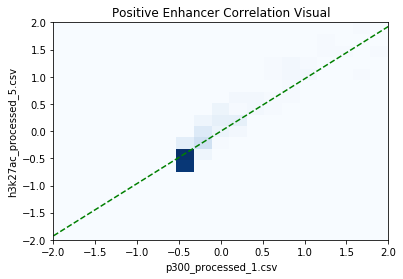

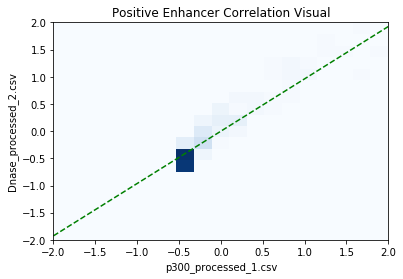

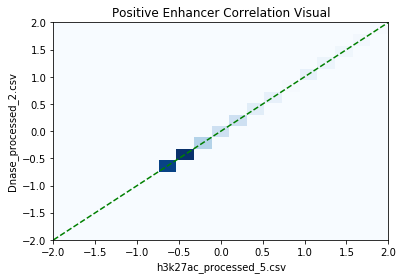

In [85]:
x = ['p300_processed_1.csv', 'p300_processed_1.csv', 'h3k27ac_processed_5.csv']
y = ['h3k27ac_processed_5.csv', 'Dnase_processed_2.csv', 'Dnase_processed_2.csv'] 
for i in range(3):
    x_values = pos_std_df[x[i]]
    y_values = pos_std_df[y[i]]

    xlabel, ylabel = x[i], y[i]
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title('Positive Enhancer Correlation Visual')
    
    x_edges = np.linspace(-2, 2, 20)
    y_edges = np.linspace(-2, 2, 20)
    H, xedges, yedges = np.histogram2d(x_values, y_values, bins=(x_edges, y_edges))
    plt.pcolor(x_edges,y_edges,H.T,cmap=plt.get_cmap('Blues'))
    
    linfit = np.polyfit(x_values, y_values, 1)
    plt.plot(x_edges,x_edges*linfit[0]+linfit[1],color='g',ls='--')
    
    plt.show()


In [95]:
DEFAULT_SPLIT = float(234.0 / (234.0 + 1967.0))
TEST_SPLIT = 0.15

def report_metrics(y_test, y_pred_lbl):
    '''
    Return Precision/Recall/accuracy
    INPUT: y_test: Array of true labels
       y_pred_lbl: Array of predicted labels
    OUTPUT: Return precision, recall, accuracy, and f1 score values
    '''
    precision = precision_score(y_test, y_pred_lbl)
    recall = recall_score(y_test, y_pred_lbl)
    accuracy = accuracy_score(y_test, y_pred_lbl)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return precision, recall, accuracy, f1_score

def plot_roc(y_test, y_pred_prod, name):
    '''
    Using sklearn roc_curve plot roc curve
    INPUT:
    y_test: Array of true labels
    y_pred_prod: Array of probabilities of target variable
    OUTPUT:
    None
    '''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prod)
    plt.plot(fpr, tpr, label = name)
    plt.rcParams['font.size'] = 12
    #plt.title('ROC curve for Churn Classifier')
    plt.xlabel('Rate of False Enhancer Identification')
    plt.ylabel('Rate of True Enhancer Identification')
    plt.grid(True)
    
def custom_split(pos_examples, neg_examples, split=DEFAULT_SPLIT, test=TEST_SPLIT):
    """This function needs to be tested!"""
    
    num_pos_train = round(float(split * len(pos_examples)) * (1 - test))
    num_neg_train = round(float((1 - split) * len(neg_examples) * (1 - test))) 
    
    pos_train, neg_train, pos_label_train, neg_label_train = \
                pos_examples[:num_pos_train], neg_examples[:num_neg_train], [1]*num_pos_train, [-1]*num_neg_train
    
    X_train, y_train = pos_train.extend(neg_train), pos_label_train.extend(neg_label_train) 
    X_test, y_test = pos_examples[num_pos_train:] + neg_examples[num_neg_train:], [1]*(len(pos_examples) - num_pos_train) + [-1] * (len(neg_examples)-num_neg_train)
    
    X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    s_train = np.arange(X_train.shape[0])
    s_train = np.random.shuffle(s_train)
    
    s_test = np.arange(X_test.shape[0])
    s_test = np.random.shuffle(s_test)
    
    return X_train[s_train], y_train[s_train], X_test[s_test], y_test[s_test] 

    
def create_bins(pos_examples, neg_examples, num_bins=10): 
    """Create 10 bins - 9 train, 1 test. Each bin should contain split percent pos_examples"""
    
    train_splits = [] # Structure to store 10 lists 
    label_splits = [] # Structure to store the labels for each list
    
    num_pos_per_bin = int(round(len(pos_examples) / 10))
    print "Num to keep pos", num_pos_per_bin 
    pos_bins = [pos_examples[i:i+num_pos_per_bin] for i in range(0, len(pos_examples), num_pos_per_bin)]
    
    pos_bins = pos_bins[:-1]
    print len(pos_bins)
    
    num_neg_per_bin = int(round(len(neg_examples) / 10))
    print "Num to keep neg", num_neg_per_bin
    neg_bins = [neg_examples[j:j+num_neg_per_bin] for j in range(0, len(neg_examples), num_neg_per_bin)] 
    
    neg_bins = neg_bins[:-1]
    print len(neg_bins)
    
    
    for i, pos_ex in enumerate(pos_bins):
        pos_labels = [1] * len(pos_ex)
        neg_labels = [-1] * len(neg_bins[i]) 
        
        train_bin = pos_ex + neg_bins[i]
        label_bin = pos_labels + neg_labels
        
        train_bin, label_bin = np.array(train_bin), np.array(label_bin)
        
        indices = np.arange(219)
        np.random.shuffle(indices)
        
        train_bin, label_bin = train_bin[indices], label_bin[indices]
        
        train_splits.append(train_bin)
        label_splits.append(label_bin)
    
    return train_splits, label_splits 
         

def split_data(examples, labels):
    """Split into positive and negative examples"""
    pos_examples, neg_examples = [], [] 
    for i, ex in enumerate(examples): 
        if labels[i] == 1:
            pos_examples.append(ex)
        
        elif labels[i] == -1:
            neg_examples.append(ex)
    
    return pos_examples, neg_examples 
       
    
# TODO: 
# - TPR and FPR charts
# - F1 score, etc. 
# Cross validation function

In [94]:
training_data = train_data_df.values
training_data = training_data.astype(float)

pos_examples, neg_examples = split_data(training_data, labels)
train_splits, label_splits = create_bins(pos_examples, neg_examples)



Num to keep pos 23
10
Num to keep neg 196
10


(10, 10)

In [180]:
"""Now shallow neural net implementation."""

def neural_network(X_train, num_features): 
    model = Sequential()
    model.add(Dense(24, activation='relu', kernel_initializer='normal', input_shape=(num_features,)))
    model.add(Dropout(0.2)) 
    model.add(Dense(4, activation='relu', kernel_initializer='normal'))
#     model.add(Dense(32, activation='sigmoid', kernel_initializer='normal'))
#     model.add(Dense(12, activation='sigmoid', kernel_initializer='normal'))
#     model.add(Dense(10, activation='relu', kernel_initializer='normal'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model 


In [114]:
train_splits[0][0][0]

17.4664

In [115]:
train_shape = train_splits[0].shape
num_features = train_shape[1]

# Leave_one_out cross validation function
def leave_one_out(train_splits, label_splits, index=0):
    X_test, y_test = train_splits[index], label_splits[index]
    X_train, y_train = [], []
     
    for i in range(len(train_splits)):
        if i == index: continue 
        
        x_bin, y_bin = train_splits[i], label_splits[i]
        for j, ex in enumerate(x_bin):
            X_train.append(ex)
            y_train.append(y_bin[j])
#         X_train = np.concatenate((X_train, x_bin), axis=0)
#         y_train = np.concatenate((y_train, y_bin), axis=0)
    
    return X_train, y_train, X_test, y_test


In [122]:
def cross_validation_model(train_splits, label_splits): 
    """Finish the cross validation model."""
    
    for index in range(len(train_splits)): 
        X_train, y_train, X_test, y_test = leave_one_out(train_splits, label_splits, index)
        pass

In [204]:
X_train, y_train, X_test, y_test = leave_one_out(train_splits, label_splits) # make CV function

# Preprocessing ... 

# sc = StandardScaler()
# sc2 = StandardScaler()
# train_x = sc.fit_transform(X_train)
# train_y = sc2.fit_transform(y_train)

# test_x = sc.transform(X_test)
# test_y = sc2.transform(y_test)

X_train = np.array(X_train)

y_train = np.array(y_train)

np.random.seed(42) 
model = neural_network(X_train, num_features) 
checkpointer = ModelCheckpoint('weights.hdf5', verbose=1, save_best_only=True)

hist = model.fit(X_train, y_train, batch_size=100, epochs=3, verbose=1) # Tuning? idk what's up here
# hist = model.fit(X_train, y_train, batch_size=100, epochs=5, validation_data=(X_test, y_test), verbose=1, callbacks=[checkpointer])

# hist = model.fit(X_train, y_train, batch_size=10, epochs=50, validation_split=0.10, verbose=1, callbacks=[checkpointer])

Epoch 1/3
1971/1971 [==============================] - 2s 766us/step - loss: 0.6409
Epoch 2/3
1971/1971 [==============================] - 0s 17us/step - loss: 0.1649
Epoch 3/3
1971/1971 [==============================] - 0s 15us/step - loss: -1.3546


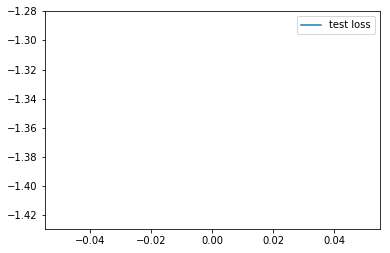

In [205]:
plt.plot(hist.history['loss'][2:100], label='test loss')
# plt.plot(hist.history['val_loss'][2:100], label='val loss')
plt.legend()
plt.show()

In [208]:
scores = model.evaluate(X_test, y_test)         
print("\n%s: %.8f" % (model.metrics_names[0], scores))
print(model.predict(X_test),y_test)

219/219 [==============================] - 0s 1ms/step

loss: -1.85357345
(array([[  5.15641719e-02],
       [  2.25138545e-01],
       [  3.91352355e-01],
       [  2.69412488e-01],
       [  1.93057284e-01],
       [  3.64554822e-01],
       [  3.63940328e-01],
       [  8.19003268e-04],
       [  4.31688815e-01],
       [  2.80139536e-01],
       [  2.36213163e-01],
       [  2.78973059e-20],
       [  2.19230278e-05],
       [  3.43315661e-01],
       [  1.34313991e-03],
       [  1.94248520e-02],
       [  4.19829458e-01],
       [  1.12738714e-01],
       [  9.33869649e-03],
       [  1.91220417e-04],
       [  2.27813333e-01],
       [  1.31178834e-03],
       [  2.44782269e-01],
       [  3.90854955e-01],
       [  7.63539597e-02],
       [  5.45751955e-03],
       [  4.50592972e-02],
       [  4.24715847e-01],
       [  6.83755497e-04],
       [  1.91816196e-01],
       [  4.24826801e-01],
       [  8.98557305e-02],
       [  2.11750204e-03],
       [  2.71938860e-01],
       

In [193]:
from keras.layers import LSTM, Embedding

def lstm(X_train, num_features): 
    model = Sequential()
#     model.add(Embedding(input_dim=num_features, output_dim=128))
    model.add(LSTM(12, input_shape=(1, 12), return_sequences=True))
    model.add(Dense(12, activation='relu', kernel_initializer='normal'))
    model.add(Dense(units=1, activation='sigmoid', kernel_initializer='normal'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model 

In [211]:
from keras.preprocessing import sequence

# train_features = sequence.pad_sequences(X_train, maxlen=200)
# test_features = sequence.pad_sequences(X_test, maxlen=200)

model2 = lstm(X_train, 12)
# history = model2.fit(X_train, y_train, batch_size=100, epochs=3, verbose=1)
# history = model.fit(train_features, y_train, batch_size=1000, epochs=3, verbose=1)